# Experimento - Detecção de falhas em rolamentos por vibração
---

### Importação das bibliotecas

In [1]:
import scipy.io
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.graph_objects as go

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

### Carregamento dos dados de vibração

In [2]:
# Carregando os dados do arquivo .mat para um dicionário python
input_data = scipy.io.loadmat('../data/01_raw/Data.mat')
output_data = scipy.io.loadmat('../data/01_raw/Targets.mat')

In [3]:
print(input_data.keys())  # Data é a entrada
print(output_data.keys()) # Targets é a saída

dict_keys(['__header__', '__version__', '__globals__', 'Data'])
dict_keys(['__header__', '__version__', '__globals__', 'Targets'])


In [4]:
input_data["Data"].shape, output_data["Targets"].shape

((178, 3571), (178, 1))

### Visualização dos dados

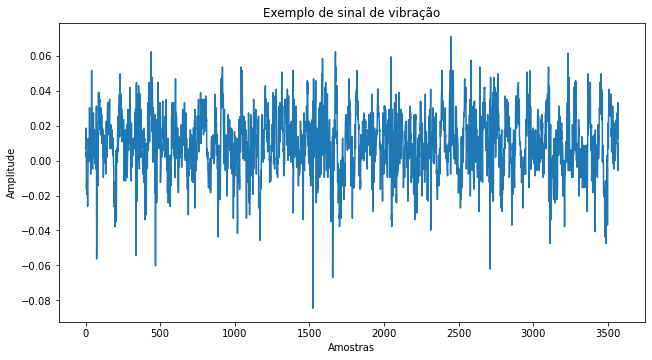

In [5]:
# Increase image size
fig, ax = plt.subplots()
plt.plot(input_data["Data"][0, :])
fig.set_size_inches(10.5, 5.5)
plt.title("Exemplo de sinal de vibração")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.show()

### Processamento dos dados em frequência

In [6]:
X_data = input_data["Data"]                    # Acessando os dados de entrada
Y_data = output_data["Targets"].T.tolist()[0]  # Acessando os dados de saída

X_pxx_data = []
for ind in range(X_data.shape[0]):
    x = X_data[ind,:]
    f, Pxx_den = signal.periodogram(x, 1)
    X_pxx_data.append(Pxx_den.tolist())

#### Visualizando os sinais em frequência

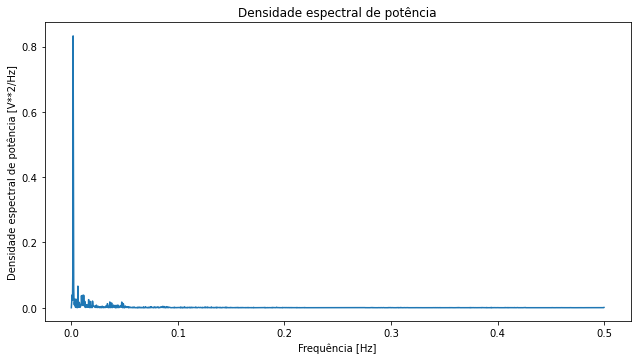

In [7]:
fig, ax = plt.subplots()
plt.plot(f, Pxx_den)
fig.set_size_inches(10.5, 5.5)
plt.title("Densidade espectral de potência")
plt.xlabel("Frequência [Hz]")
plt.ylabel("Densidade espectral de potência [V**2/Hz]")
plt.show()

#### Visualizando os padrões comuns entre rolamentos

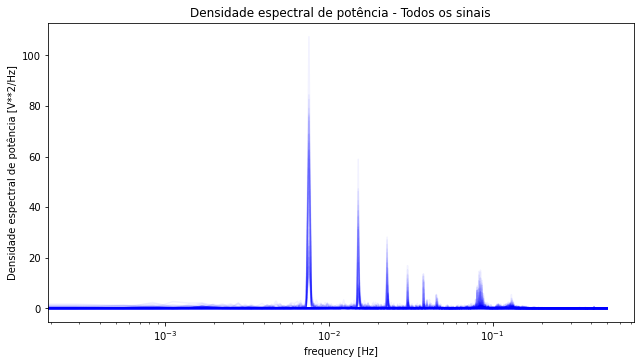

In [8]:
fig, ax = plt.subplots()

for i in range(0, input_data["Data"].shape[0]):
    f, Pxx_den = signal.periodogram(input_data["Data"][i,:], 1)
    plt.plot(f, Pxx_den, color='blue', alpha=0.05)              # Plot com baixa opacidade

fig.set_size_inches(10.5, 5.5)
plt.title("Densidade espectral de potência - Todos os sinais")
plt.xlabel('frequency [Hz]')
plt.ylabel('Densidade espectral de potência [V**2/Hz]')
plt.xscale('log')
plt.show()

#### Visualizando padrões para falha específica

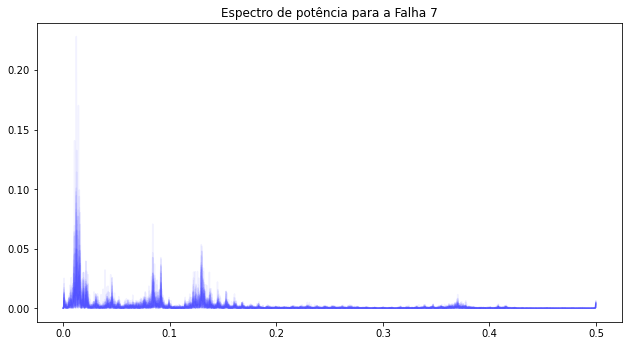

In [40]:
out_type = 7 # Output type que queremos visualizar o padrão de espectro
output_list = output_data["Targets"].T.tolist()[0]

fig, axes = plt.subplots()
fig.set_size_inches(10.5, 5.5)
indexes = [i for i, x in enumerate(output_list) if x == out_type]
for i in indexes:
    f, Pxx_den = signal.periodogram(input_data["Data"][i,:], 1)
    axes.plot(f, Pxx_den, color='blue', alpha=0.05)
if out_type == 9:
    plt.title("Espectro de potência para rolamento sem falha")
else:
    plt.title("Espectro de potência para a Falha {}".format(out_type))
plt.show()

### Criando a estrutura de dados para o modelo de Machine Learning

In [10]:
df = pd.DataFrame(data=X_pxx_data) # Transformando a lista de listas em um DataFrame
df["y"] = Y_data                   # Adicionando a coluna de saída

In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1777,1778,1779,1780,1781,1782,1783,1784,1785,y
count,1.780000e+02,1.780000e+02,178.000000,178.000000,178.000000,1.780000e+02,178.000000,178.000000,178.000000,178.000000,...,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,178.000000,178.000000,178.000000
mean,5.399140e-32,8.718457e-02,0.081909,0.127593,0.092878,1.184442e-01,0.192380,0.150816,0.093811,0.093895,...,3.506271e-03,3.498275e-03,3.502296e-03,3.956574e-03,0.003721,4.356906e-03,4.328109e-03,0.002945,0.004894,5.005618
std,1.457789e-31,2.446230e-01,0.221014,0.322948,0.286743,2.880991e-01,0.379117,0.295799,0.256477,0.246490,...,7.222896e-03,8.781291e-03,7.232187e-03,8.087455e-03,0.007296,9.765214e-03,9.971090e-03,0.005193,0.007562,2.598342
min,0.000000e+00,6.550733e-07,0.000021,0.000213,0.000034,5.839091e-07,0.000007,0.000041,0.000026,0.000012,...,6.303312e-07,1.665630e-07,1.969819e-07,5.923252e-07,0.000002,7.626241e-07,3.295757e-07,0.000014,0.000048,1.000000
25%,1.126165e-33,7.328016e-04,0.001090,0.005036,0.002736,2.161012e-03,0.002494,0.001983,0.002361,0.002440,...,5.249393e-05,7.964108e-05,6.008402e-05,7.260451e-05,0.000068,1.190278e-04,1.192129e-04,0.000220,0.000854,3.000000
50%,6.682454e-33,3.569882e-03,0.004314,0.009631,0.006987,8.031676e-03,0.010447,0.006570,0.006366,0.007851,...,3.042011e-04,2.905766e-04,4.375962e-04,5.880634e-04,0.000477,3.823617e-04,5.046233e-04,0.000579,0.001826,5.000000
75%,2.292951e-32,1.696078e-02,0.018878,0.030755,0.028497,7.736363e-02,0.131166,0.195026,0.048065,0.032999,...,4.352684e-03,3.010652e-03,3.612468e-03,3.966122e-03,0.004062,3.618767e-03,5.573490e-03,0.003314,0.005696,7.000000
max,8.491687e-31,1.726429e+00,1.279868,2.341678,2.711937,2.099541e+00,2.153364,1.653574,1.854312,1.818910,...,4.540291e-02,8.019352e-02,6.203495e-02,5.318468e-02,0.042126,8.078398e-02,8.607374e-02,0.029614,0.045794,9.000000


### Dividindo os dados em teste e trainamento

In [12]:
features, y = df.iloc[:, :-1], df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42)

### Reduzindo a dimensionalidade dos dados

In [13]:
X_train.shape, X_test.shape

((142, 1786), (36, 1786))

In [14]:
# Reduzindo a dimensionalidade dos dados utilizando PCA
pca = PCA()
pca.fit(X_train)

PCA()

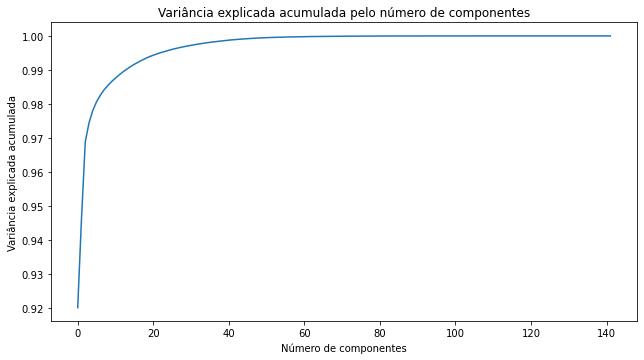

In [15]:
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.title('Variância explicada acumulada pelo número de componentes')
fig.set_size_inches(10.5, 5.5)
plt.show()

#### Utilizando a redução para 20 componentes

In [16]:
# PCA com 40 componentes principais para redução de dimensionalidade
#
pca = PCA(n_components=40)
pca.fit(X_train)

# Transformando os dados de treino
X_train_pca = pca.transform(X_train)

In [17]:
X_train_pca.shape

(142, 40)

#### Normalização dos dados

In [18]:
# Normalizando os dados de treino utilizando MinMaxScaler
# para manter as proporções de amplitudes entre frequências
ss = MinMaxScaler()
ss.fit(X_train_pca)

# Normalizando os dados de treino
X_train_normalized = ss.transform(X_train_pca)

In [19]:
X_train_pca

array([[-1.11787319e+01, -1.74393708e+00, -1.41819169e+00, ...,
        -4.75631176e-02,  9.16744224e-02,  4.28853810e-03],
       [-1.11692855e+01, -1.74161083e+00, -1.47592569e+00, ...,
        -1.46965175e-02, -5.20788536e-02,  1.65804858e-02],
       [-1.10076144e+01, -3.42561710e-01, -1.08389292e+00, ...,
         4.03176154e-01, -1.51556952e-01, -1.70322168e-01],
       ...,
       [-1.12205832e+01, -1.76051733e+00, -1.45899433e+00, ...,
        -8.38518586e-03, -3.74895144e-02,  2.27725418e-02],
       [-1.10116509e+01, -1.43697045e+00, -1.34036125e+00, ...,
         9.16769331e-01, -4.24047545e-03, -1.71842605e-01],
       [ 8.96217921e+00, -4.75201693e+00,  1.01341669e+01, ...,
        -2.93715877e-01, -1.18935888e-01,  2.30344212e-01]])

In [20]:
X_train_normalized

array([[0.00143617, 0.16462321, 0.33929088, ..., 0.44265933, 0.42839607,
        0.46042805],
       [0.00151   , 0.16472044, 0.33777485, ..., 0.45602261, 0.37951115,
        0.46404609],
       [0.00277359, 0.22319365, 0.34806916, ..., 0.62592599, 0.34568251,
        0.40903276],
       ...,
       [0.00110907, 0.16393024, 0.33821945, ..., 0.45858874, 0.38447242,
        0.46586867],
       [0.00274204, 0.17745287, 0.34133461, ..., 0.8347485 , 0.39577913,
        0.40858523],
       [0.15885315, 0.03890061, 0.64264186, ..., 0.34257577, 0.35677567,
        0.52696577]])

### Criação/treinamento dos modelos de Machine Learning

#### LogisticRegression

In [21]:
# Treinando um modelo de Regressão Logística
#
lr_model = LogisticRegression(random_state=43)
lr_model.fit(X_train_normalized, y_train)

LogisticRegression(random_state=43)

#### LGBMClassifier

In [22]:
# Treinando um modelo de LGBM
#
model = LGBMClassifier(random_state=43)
model.fit(X_train_normalized, y_train)

LGBMClassifier(random_state=43)

In [23]:
import pickle

with open('../data/06_models/lgbm_file.pkl', 'wb') as f:
    pickle.dump(model, f)

In [24]:
lgb_model_size = 676_000
nn_model_size  = 1_500_000_000

In [25]:
nn_model_size / lgb_model_size

2218.9349112426034

### Validação

#### Processamento dos dados de teste

In [23]:
# Processando os dados de teste para avaliação
# dos modelos treinados anteriormente
X_test_pca = pca.transform(X_test)
X_test_pca = ss.transform(X_test_pca)

#### Gerando as predições

In [42]:
# Predição dos modelos treinados
y_pred_lr = lr_model.predict(X_test_pca)
y_pred_lgbm = model.predict(X_test_pca)

# Definição dos labels para display
y_display_labels = list(set(y_test.tolist()))

#### LogisticRegression resultados

In [44]:
# Avaliação dos modelos treinados utilizando a acurácia e matriz de confusão
acc = accuracy_score(y_test, y_pred_lr, normalize=True)
cm = confusion_matrix(y_test, y_pred_lr, normalize='true')

print(f"Accuracy: {100*acc:.2f} %")

Accuracy: 72.22 %


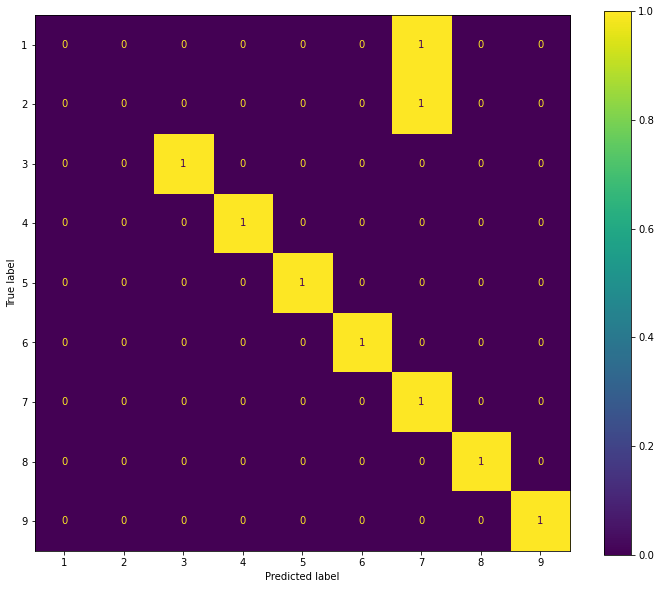

In [45]:
cmp = ConfusionMatrixDisplay(cm, display_labels=y_display_labels)
fig, ax = plt.subplots(figsize=(12,10))
_ = cmp.plot(ax=ax)

#### LGBMClassifier resultados

In [47]:
# Avaliação dos modelos treinados utilizando a acurácia e matriz de confusão
acc = accuracy_score(y_test, y_pred_lgbm, normalize=True)
cm = confusion_matrix(y_test, y_pred_lgbm, normalize='true')

print(f"Accuracy: {100*acc:.2f} %")

Accuracy: 97.22 %


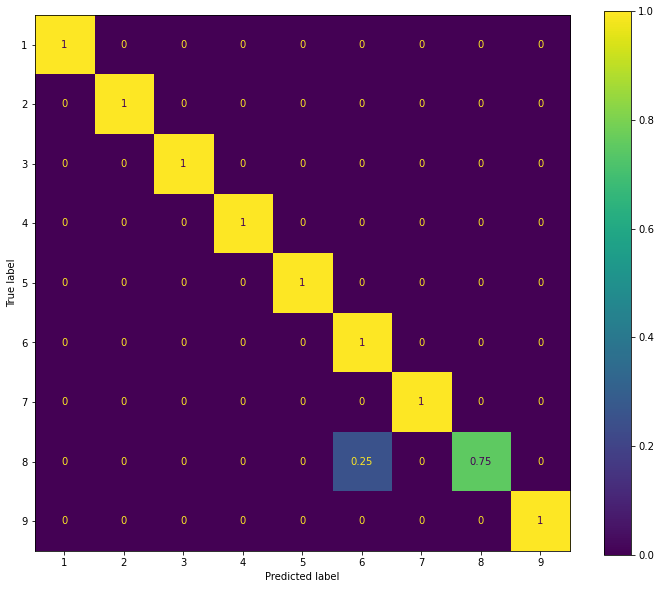

In [48]:
cmp = ConfusionMatrixDisplay(cm, display_labels=y_display_labels)
fig, ax = plt.subplots(figsize=(12,10))
_ = cmp.plot(ax=ax)